In [93]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [3]:
#Importing data into dataframe
df = pd.read_csv('../data/raw/fff_Bw_1min.dat', delim_whitespace=True)

#Adding column names to dataframe
df.columns = ['year', 'month', 'day', 'hour', 'minute', 
              'L', 'MLT', 'MLAT', 'AL Index', 
              'KP Index', 'Satellite Flag', 'B']

# Converting year + month + day + hour + minute + second to datetime
datetime = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])

# Adding datetime column to dataframe
df.insert(0, "datetime", datetime, True)

# Dropping useless columns
df = df.drop(['year', 'month', 'day', 'hour', 'minute', 'AL Index', 'KP Index'], axis=1)

df.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,datetime,L,MLT,MLAT,Satellite Flag,B
0,2010-06-01 10:51:00,9.13,22.69,-1.43,0.0,0.000765
1,2010-06-01 10:52:00,9.03,22.7,-1.44,0.0,0.000699
2,2010-06-01 10:53:00,9.02,22.7,-1.45,0.0,0.000786
3,2010-06-01 10:54:00,9.06,22.71,-1.46,0.0,0.000748
4,2010-06-01 10:55:00,8.95,22.72,-1.48,0.0,0.000933


In [4]:
df['Satellite Flag'].value_counts()

0.000000    482881
1.000000    461864
2.000000    459017
0.001010      2519
0.001040      2455
             ...  
0.169000         1
0.236000         1
0.000566         1
0.088200         1
0.278000         1
Name: Satellite Flag, Length: 2334, dtype: int64

In [5]:
# Converting satellite flag values to int
df['Satellite Flag'] = df['Satellite Flag'].astype(int)
df['Satellite Flag'].value_counts()

0    738633
1    461864
2    459017
Name: Satellite Flag, dtype: int64

In [96]:
# Splitting data into 3 frames for each satellite

df_sat = []
df_sat.append(df.loc[(df['Satellite Flag'] == 0)])
df_sat.append(df.loc[(df['Satellite Flag'] == 1)])
df_sat.append(df.loc[(df['Satellite Flag'] == 2)])

df_sat[0]['Satellite Flag'].value_counts()

0    738633
Name: Satellite Flag, dtype: int64

In [97]:
df_sat[0] = df_sat[0].sort_values(by = 'datetime')

(array([733773., 734138., 734503., 734869., 735234., 735599., 735964.,
        736330., 736695.]), <a list of 9 Text xticklabel objects>)

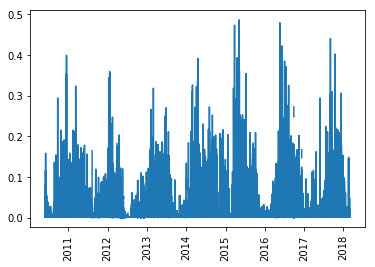

In [98]:
# Plotting data for 1 satellite to see if there is a trend
plt.plot(df_sat[0]['datetime'], df_sat[0]['B'])
plt.xticks(rotation='vertical')

In [99]:
# Check if measurements are being taken every minute or not
df_sat[0]['datetime_diff'] = df_sat[0]['datetime'].diff()
#pd.set_option('display.max_rows', df_sat0_sorted.shape[0]+1)
#df_sat[0]['datetime_diff'].value_counts()

In [100]:
# Total missing time
print("Total missing time with 1 minute timesteps:", df_sat[0]['datetime_diff'].sum())

print("Total missing time with 1 hour timesteps:", 
      df_sat[0]['datetime_diff'].where(df_sat[0]['datetime_diff'] > '01:00:00').sum())

print("Total missing time with 2 day timesteps:", 
      df_sat[0]['datetime_diff'].where(df_sat[0]['datetime_diff'] >= '2 days').sum())

print("Total missing time with 10 days timesteps:", 
      df_sat[0]['datetime_diff'].where(df_sat[0]['datetime_diff'] > '10 days').sum())

Total missing time with 1 minute timesteps: 2829 days 03:52:00
Total missing time with 1 hour timesteps: 2346 days 11:01:00
Total missing time with 2 day timesteps: 849 days 16:21:00
Total missing time with 10 days timesteps: 31 days 17:51:00


In [101]:
print((2829 - 643432/(24*60))/365)

6.526499238964993


In [107]:
# Setting index on datetime
df_sat[0] = df_sat[0].set_index('datetime')

# Taking average of every day
df_sampled = df_sat[0].resample('1440Min').mean()

In [106]:
print(df_sampled)

                   L        MLAT  Satellite Flag         B
datetime                                                  
2010-06-01  6.561608   -1.397487             0.0  0.001997
2010-06-02  6.689676   -1.489676             0.0  0.001322
2010-06-03  6.329808   -1.194904             0.0  0.021389
2010-06-04  6.381292   -1.186986             0.0  0.010071
2010-06-05  6.478571   -1.288878             0.0  0.001085
2010-06-06  6.615187   -1.358770             0.0  0.006487
2010-06-07  6.670546   -1.379672             0.0  0.002899
2010-06-08       NaN         NaN             NaN       NaN
2010-06-09       NaN         NaN             NaN       NaN
2010-06-10       NaN         NaN             NaN       NaN
2010-06-11       NaN         NaN             NaN       NaN
2010-06-12       NaN         NaN             NaN       NaN
2010-06-13       NaN         NaN             NaN       NaN
2010-06-14  7.082606   -1.350909             0.0  0.003911
2010-06-15       NaN         NaN             NaN       N

(array([733773., 734138., 734503., 734869., 735234., 735599., 735964.,
        736330., 736695.]), <a list of 9 Text xticklabel objects>)

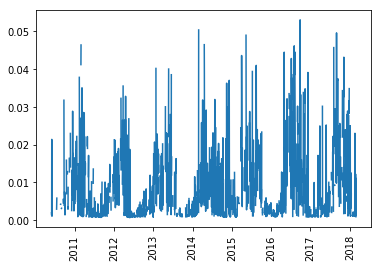

In [109]:
# Plotting to visualize extent of missing data
plt.plot(df_sampled['B'])
plt.xticks(rotation='vertical')

In [110]:
# Imputing using interpolation with different methods

def interpolate(df, col):
    df = df.assign(InterpolateLinear    = df[col].interpolate(method='linear'))
    df = df.assign(InterpolateTime      = df[col].interpolate(method='time'))
    df = df.assign(InterpolateQuadratic = df[col].interpolate(method='quadratic'))
    df = df.assign(InterpolateCubic     = df[col].interpolate(method='cubic'))
    df = df.assign(InterpolateSLinear   = df[col].interpolate(method='slinear'))
    df = df.assign(InterpolateAkima     = df[col].interpolate(method='akima'))
    df = df.assign(InterpolatePoly5     = df[col].interpolate(method='polynomial', order=5)) 
    df = df.assign(InterpolatePoly7     = df[col].interpolate(method='polynomial', order=7))
    df = df.assign(InterpolateSpline3   = df[col].interpolate(method='spline', order=3))
    df = df.assign(InterpolateSpline4   = df[col].interpolate(method='spline', order=4))
    df = df.assign(InterpolateSpline5   = df[col].interpolate(method='spline', order=5))
    return df

In [111]:
df_sampled = interpolate(df_sampled, 'B')
df_sampled.head()

,L,MLAT,Satellite Flag,B,InterpolateLinear,InterpolateTime,InterpolateQuadratic,InterpolateCubic,InterpolateSLinear,InterpolateAkima,InterpolatePoly5,InterpolatePoly7,InterpolateSpline3,InterpolateSpline4,InterpolateSpline5
datetime,,,,,,,,,,,,,,,
2010-06-01,6.561608,-1.397487,0.0,0.001997,0.001997,0.001997,0.001997,0.001997,0.001997,0.001997,0.001997,0.001997,0.001997,0.001997,0.001997
2010-06-02,6.689676,-1.489676,0.0,0.001322,0.001322,0.001322,0.001322,0.001322,0.001322,0.001322,0.001322,0.001322,0.001322,0.001322,0.001322
2010-06-03,6.329808,-1.194904,0.0,0.021389,0.021389,0.021389,0.021389,0.021389,0.021389,0.021389,0.021389,0.021389,0.021389,0.021389,0.021389
2010-06-04,6.381292,-1.186986,0.0,0.010071,0.010071,0.010071,0.010071,0.010071,0.010071,0.010071,0.010071,0.010071,0.010071,0.010071,0.010071
2010-06-05,6.478571,-1.288878,0.0,0.001085,0.001085,0.001085,0.001085,0.001085,0.001085,0.001085,0.001085,0.001085,0.001085,0.001085,0.001085


(array([733773., 734138., 734503., 734869., 735234., 735599., 735964.,
        736330., 736695.]), <a list of 9 Text xticklabel objects>)

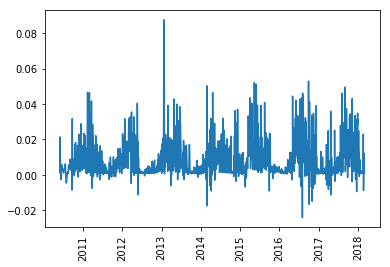

In [112]:
# Plotting to visualize with filled data
plt.plot(df_sampled['InterpolateQuadratic'])
plt.xticks(rotation='vertical')

In [114]:
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

def prepare_data(df, col):
    # Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    df = scaler.fit_transform(np.array(df[col]).reshape(-1,1)) #The reshape converts the row of values into array with several rows with 1 value each

    #Train test split
    training_size = 0.7
    training_row_limit = int(training_size*df.shape[0])
    sections = np.split(df, indices_or_sections = [training_row_limit], axis = 0)
    train = sections[0]
    test = sections[1]

    X_train, y_train = create_dataset(train, time_step)
    X_test, ytest = create_dataset(test, time_step)

    # reshape input to be [samples, time steps, features] which is required for LSTM
    X_train_reshaped =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    
    return X_train_reshaped, X_test_reshaped, y_train, ytest, scaler

In [115]:
### Create the Stacked LSTM model

def create_model(timestep):
    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(timestep,1)))
    model.add(LSTM(50,return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model


In [116]:
def results_analysis(X_train_reshaped, X_test_reshaped, y_train, ytest, scaler):
    ### Lets Do the prediction and check performance metrics
    train_predict=model.predict(X_train_reshaped)
    test_predict=model.predict(X_test_reshaped)

    ##Transformback to original form, reverse the effect of scaling
    train_predict_unscaled = scaler.inverse_transform(train_predict)
    test_predict_unscaled = scaler.inverse_transform(test_predict)
    y_train_unscaled = scaler.inverse_transform(np.array(y_train).reshape(-1,1))
    ytest_unscaled = scaler.inverse_transform(np.array(ytest).reshape(-1,1))
    
    ### Calculate RMSE performance metrics. RMSE on training data gives a benchmark to compare against.
    import math
    from sklearn.metrics import mean_squared_error
    training_RMSE = math.sqrt(mean_squared_error(y_train_unscaled, train_predict_unscaled))

    ### Test Data RMSE
    test_RMSE = math.sqrt(mean_squared_error(ytest_unscaled, test_predict_unscaled))
    return training_RMSE, test_RMSE

In [117]:
#Iterate over columns
Interpolation_cols = [
        'InterpolateLinear',
        'InterpolateTime',
        'InterpolateQuadratic',
        'InterpolateCubic',
        'InterpolateSLinear',
        'InterpolateAkima',
        'InterpolatePoly5',
        'InterpolatePoly7',
        'InterpolateSpline3',
        'InterpolateSpline4',
        'InterpolateSpline5'
    ]
    
for col in Interpolation_cols:
    # HyperParameters
    # Timesteps is how many previous observations we are dependent on
    time_step = 100
    X_train_reshaped, X_test_reshaped, y_train, ytest, scaler = prepare_data(df_sampled, col)
    model = create_model(time_step)
    model.fit(X_train_reshaped,y_train,validation_data=(X_test_reshaped,ytest),epochs=100,batch_size=64,verbose=1)
    training_RMSE, test_RMSE = results_analysis(X_train_reshaped, X_test_reshaped, y_train, ytest, scaler)
    print('For interpolation method :', col)
    print('Training data error :', training_RMSE)
    print('Testing data error :', test_RMSE)

Train on 1879 samples, validate on 749 samples
Epoch 1/100
1879/1879 [==============================] - 12s 6ms/step - loss: 0.0219 - val_loss: 0.0255
Epoch 2/100
1879/1879 [==============================] - 8s 4ms/step - loss: 0.0165 - val_loss: 0.0248
Epoch 3/100
1879/1879 [==============================] - 8s 4ms/step - loss: 0.0163 - val_loss: 0.0252
Epoch 4/100
1879/1879 [==============================] - 8s 4ms/step - loss: 0.0161 - val_loss: 0.0246
Epoch 5/100
1879/1879 [==============================] - 9s 5ms/step - loss: 0.0163 - val_loss: 0.0249
Epoch 6/100
1879/1879 [==============================] - 9s 5ms/step - loss: 0.0159 - val_loss: 0.0243
Epoch 7/100
1879/1879 [==============================] - 9s 5ms/step - loss: 0.0160 - val_loss: 0.0241
Epoch 8/100
1879/1879 [==============================] - 9s 5ms/step - loss: 0.0154 - val_loss: 0.0234
Epoch 9/100
1879/1879 [==============================] - 10s 5ms/step - loss: 0.0151 - val_loss: 0.0229
Epoch 10/100
1879/1879 [

1879/1879 [==============================] - 13s 7ms/step - loss: 0.0111 - val_loss: 0.0185
Epoch 79/100
1879/1879 [==============================] - 14s 7ms/step - loss: 0.0111 - val_loss: 0.0185
Epoch 80/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0110 - val_loss: 0.0187
Epoch 81/100
1879/1879 [==============================] - 14s 7ms/step - loss: 0.0111 - val_loss: 0.0188
Epoch 82/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0111 - val_loss: 0.0186
Epoch 83/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0112 - val_loss: 0.0188
Epoch 84/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0112 - val_loss: 0.0186
Epoch 85/100
1879/1879 [==============================] - 14s 7ms/step - loss: 0.0112 - val_loss: 0.0187
Epoch 86/100
1879/1879 [==============================] - 14s 7ms/step - loss: 0.0111 - val_loss: 0.0185
Epoch 87/100
1879/1879 [==============================] - 17s 9ms/st

1879/1879 [==============================] - 12s 7ms/step - loss: 0.0111 - val_loss: 0.0188
Epoch 55/100
1879/1879 [==============================] - 12s 7ms/step - loss: 0.0111 - val_loss: 0.0188
Epoch 56/100
1879/1879 [==============================] - 12s 7ms/step - loss: 0.0111 - val_loss: 0.0186
Epoch 57/100
1879/1879 [==============================] - 12s 7ms/step - loss: 0.0111 - val_loss: 0.0189
Epoch 58/100
1879/1879 [==============================] - 12s 7ms/step - loss: 0.0111 - val_loss: 0.0186
Epoch 59/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0111 - val_loss: 0.0186
Epoch 60/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0112 - val_loss: 0.0187
Epoch 61/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0111 - val_loss: 0.0186
Epoch 62/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0111 - val_loss: 0.0186
Epoch 63/100
1879/1879 [==============================] - 13s 7ms/st

1879/1879 [==============================] - 11s 6ms/step - loss: 0.0029 - val_loss: 0.0048
Epoch 31/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0029 - val_loss: 0.0048
Epoch 32/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0029 - val_loss: 0.0054
Epoch 33/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 34/100
1879/1879 [==============================] - 10s 6ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 35/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 36/100
1879/1879 [==============================] - 10s 6ms/step - loss: 0.0029 - val_loss: 0.0050
Epoch 37/100
1879/1879 [==============================] - 10s 5ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 38/100
1879/1879 [==============================] - 10s 6ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 39/100
1879/1879 [==============================] - 11s 6ms/st

1879/1879 [==============================] - 10s 6ms/step - loss: 0.0065 - val_loss: 0.0084
Epoch 7/100
1879/1879 [==============================] - 10s 6ms/step - loss: 0.0067 - val_loss: 0.0085
Epoch 8/100
1879/1879 [==============================] - 10s 6ms/step - loss: 0.0066 - val_loss: 0.0084
Epoch 9/100
1879/1879 [==============================] - 10s 6ms/step - loss: 0.0065 - val_loss: 0.0085
Epoch 10/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0066 - val_loss: 0.0084
Epoch 11/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0065 - val_loss: 0.0083
Epoch 12/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0066 - val_loss: 0.0088
Epoch 13/100
1879/1879 [==============================] - 10s 6ms/step - loss: 0.0065 - val_loss: 0.0083
Epoch 14/100
1879/1879 [==============================] - 10s 6ms/step - loss: 0.0064 - val_loss: 0.0083
Epoch 15/100
1879/1879 [==============================] - 11s 6ms/step 

1879/1879 [==============================] - 11s 6ms/step - loss: 0.0032 - val_loss: 0.0052
Epoch 85/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0031 - val_loss: 0.0052
Epoch 86/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0031 - val_loss: 0.0052
Epoch 87/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0031 - val_loss: 0.0053
Epoch 88/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0031 - val_loss: 0.0052
Epoch 89/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0031 - val_loss: 0.0052
Epoch 90/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0031 - val_loss: 0.0052
Epoch 91/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0031 - val_loss: 0.0052
Epoch 92/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0031 - val_loss: 0.0054
Epoch 93/100
1879/1879 [==============================] - 11s 6ms/st

1879/1879 [==============================] - 11s 6ms/step - loss: 0.0111 - val_loss: 0.0187
Epoch 61/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0112 - val_loss: 0.0186
Epoch 62/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0112 - val_loss: 0.0186
Epoch 63/100
1879/1879 [==============================] - 12s 7ms/step - loss: 0.0111 - val_loss: 0.0187
Epoch 64/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0112 - val_loss: 0.0188
Epoch 65/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0111 - val_loss: 0.0185
Epoch 66/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0111 - val_loss: 0.0186
Epoch 67/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0112 - val_loss: 0.0187
Epoch 68/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0112 - val_loss: 0.0187
Epoch 69/100
1879/1879 [==============================] - 11s 6ms/st

1879/1879 [==============================] - 12s 6ms/step - loss: 0.0088 - val_loss: 0.0153
Epoch 37/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0087 - val_loss: 0.0149
Epoch 38/100
1879/1879 [==============================] - 12s 7ms/step - loss: 0.0087 - val_loss: 0.0154
Epoch 39/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0087 - val_loss: 0.0152
Epoch 40/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0087 - val_loss: 0.0149
Epoch 41/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0087 - val_loss: 0.0155
Epoch 42/100
1879/1879 [==============================] - 12s 6ms/step - loss: 0.0087 - val_loss: 0.0149
Epoch 43/100
1879/1879 [==============================] - 12s 7ms/step - loss: 0.0087 - val_loss: 0.0154
Epoch 44/100
1879/1879 [==============================] - 12s 7ms/step - loss: 0.0088 - val_loss: 0.0150
Epoch 45/100
1879/1879 [==============================] - 13s 7ms/st

1879/1879 [==============================] - 12s 6ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 13/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 14/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0033 - val_loss: 0.0043
Epoch 15/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 16/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 17/100
1879/1879 [==============================] - 14s 7ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 18/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0034 - val_loss: 0.0044
Epoch 19/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 20/100
1879/1879 [==============================] - 11s 6ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 21/100
1879/1879 [==============================] - 11s 6ms/st

1879/1879 [==============================] - 12s 6ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 91/100
1879/1879 [==============================] - 12s 6ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 92/100
1879/1879 [==============================] - 12s 6ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 93/100
1879/1879 [==============================] - 14s 8ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 94/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 95/100
1879/1879 [==============================] - 12s 6ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 96/100
1879/1879 [==============================] - 12s 7ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 97/100
1879/1879 [==============================] - 17s 9ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 98/100
1879/1879 [==============================] - 14s 7ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 99/100
1879/1879 [==============================] - 12s 6ms/st

Epoch 66/100
1879/1879 [==============================] - 14s 8ms/step - loss: 5.5927e-04 - val_loss: 9.0842e-04
Epoch 67/100
1879/1879 [==============================] - 14s 7ms/step - loss: 5.0800e-04 - val_loss: 9.0352e-04
Epoch 68/100
1879/1879 [==============================] - 14s 7ms/step - loss: 4.9865e-04 - val_loss: 8.7822e-04
Epoch 69/100
1879/1879 [==============================] - 13s 7ms/step - loss: 5.1117e-04 - val_loss: 8.7764e-04
Epoch 70/100
1879/1879 [==============================] - 14s 7ms/step - loss: 4.9247e-04 - val_loss: 8.7294e-04
Epoch 71/100
1879/1879 [==============================] - 12s 6ms/step - loss: 5.3418e-04 - val_loss: 8.9710e-04
Epoch 72/100
1879/1879 [==============================] - 12s 6ms/step - loss: 5.4956e-04 - val_loss: 9.4009e-04
Epoch 73/100
1879/1879 [==============================] - 12s 6ms/step - loss: 5.0477e-04 - val_loss: 9.4581e-04
Epoch 74/100
1879/1879 [==============================] - 12s 6ms/step - loss: 5.0117e-04 - val_

Epoch 40/100
1879/1879 [==============================] - 12s 6ms/step - loss: 0.0135 - val_loss: 0.0221
Epoch 41/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0132 - val_loss: 0.0213
Epoch 42/100
1879/1879 [==============================] - 14s 7ms/step - loss: 0.0134 - val_loss: 0.0216
Epoch 43/100
1879/1879 [==============================] - 12s 6ms/step - loss: 0.0131 - val_loss: 0.0215
Epoch 44/100
1879/1879 [==============================] - 14s 8ms/step - loss: 0.0132 - val_loss: 0.0223
Epoch 45/100
1879/1879 [==============================] - 14s 7ms/step - loss: 0.0131 - val_loss: 0.0220
Epoch 46/100
1879/1879 [==============================] - 15s 8ms/step - loss: 0.0131 - val_loss: 0.0215
Epoch 47/100
1879/1879 [==============================] - 15s 8ms/step - loss: 0.0130 - val_loss: 0.0213
Epoch 48/100
1879/1879 [==============================] - 15s 8ms/step - loss: 0.0131 - val_loss: 0.0216
Epoch 49/100
1879/1879 [==============================]

1879/1879 [==============================] - 14s 7ms/step - loss: 0.0134 - val_loss: 0.0218
Epoch 17/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0135 - val_loss: 0.0220
Epoch 18/100
1879/1879 [==============================] - 12s 7ms/step - loss: 0.0136 - val_loss: 0.0228
Epoch 19/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0134 - val_loss: 0.0223
Epoch 20/100
1879/1879 [==============================] - 17s 9ms/step - loss: 0.0135 - val_loss: 0.0222
Epoch 21/100
1879/1879 [==============================] - 14s 7ms/step - loss: 0.0134 - val_loss: 0.0217
Epoch 22/100
1879/1879 [==============================] - 12s 6ms/step - loss: 0.0135 - val_loss: 0.0226
Epoch 23/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0134 - val_loss: 0.0221
Epoch 24/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0133 - val_loss: 0.0222
Epoch 25/100
1879/1879 [==============================] - 12s 6ms/st

1879/1879 [==============================] - 13s 7ms/step - loss: 0.0130 - val_loss: 0.0215
Epoch 95/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0130 - val_loss: 0.0215
Epoch 96/100
1879/1879 [==============================] - 14s 8ms/step - loss: 0.0130 - val_loss: 0.0216
Epoch 97/100
1879/1879 [==============================] - 14s 7ms/step - loss: 0.0130 - val_loss: 0.0217
Epoch 98/100
1879/1879 [==============================] - 16s 8ms/step - loss: 0.0131 - val_loss: 0.0224
Epoch 99/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0130 - val_loss: 0.0214
Epoch 100/100
1879/1879 [==============================] - 14s 7ms/step - loss: 0.0130 - val_loss: 0.0214
For interpolation method : InterpolateSpline4
Training data error : 0.006014142279481997
Testing data error : 0.007634154383707699
Train on 1879 samples, validate on 749 samples
Epoch 1/100
1879/1879 [==============================] - 20s 11ms/step - loss: 0.0164 - val_loss: 0

1879/1879 [==============================] - 20s 11ms/step - loss: 0.0130 - val_loss: 0.0223
Epoch 71/100
1879/1879 [==============================] - 23s 12ms/step - loss: 0.0131 - val_loss: 0.0213
Epoch 72/100
1879/1879 [==============================] - 15s 8ms/step - loss: 0.0130 - val_loss: 0.0226
Epoch 73/100
1879/1879 [==============================] - 14s 7ms/step - loss: 0.0131 - val_loss: 0.0215
Epoch 74/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0130 - val_loss: 0.0218
Epoch 75/100
1879/1879 [==============================] - 14s 7ms/step - loss: 0.0130 - val_loss: 0.0213
Epoch 76/100
1879/1879 [==============================] - 15s 8ms/step - loss: 0.0130 - val_loss: 0.0215
Epoch 77/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0130 - val_loss: 0.0215
Epoch 78/100
1879/1879 [==============================] - 13s 7ms/step - loss: 0.0130 - val_loss: 0.0218
Epoch 79/100
1879/1879 [==============================] - 12s 6ms/

In [ ]:
# Results:

"""

For interpolation method : InterpolateLinear
Training data error : 0.005456239950998813
Testing data error : 0.007093278378945819


For interpolation method : InterpolateTime
Training data error : 0.005477038522347323
Testing data error : 0.007131720876734925


For interpolation method : InterpolateQuadratic
Training data error : 0.005865992546418754
Testing data error : 0.00779705733860975


For interpolation method : InterpolateCubic
Training data error : 0.005842715881108312
Testing data error : 0.007768598010234367


For interpolation method : InterpolateSLinear
Training data error : 0.005420764610341041
Testing data error : 0.007093236282832488


For interpolation method : InterpolateAkima
Training data error : 0.005516494768382969
Testing data error : 0.0073144349303869574


For interpolation method : InterpolatePoly5
Training data error : 0.007184687584478991
Testing data error : 0.009490909785487429

For interpolation method : InterpolatePoly7
Training data error : 0.008025835784085032
Testing data error : 0.010842652495319606


For interpolation method : InterpolateSpline3
Training data error : 0.005935324524899346
Testing data error : 0.007660320787305758


For interpolation method : InterpolateSpline4
Training data error : 0.006014142279481997
Testing data error : 0.007634154383707699


For interpolation method : InterpolateSpline5
Training data error : 0.005938636595829336
Testing data error : 0.007770786378315712

"""

# InterpolateSLinear is the best